In [7]:
class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = np.full(num_particles, mass)  # Mass for each particle
        self.dt = dt
        self.total_time = total_time

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.time_steps = int(total_time / dt)  # Total number of time steps
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # Store trajectory

    def forces(self, positions):
        # Calculate the spring forces
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                # Calculate the spring force based on Hooke's law
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-Reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities from the state vector y
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        # Calculate forces
        F = self.forces(positions)

        # Add damping force (assumed uniform damping coefficient)
        damping_coefficient = 0.1  # Adjust this value as needed
        damping_force = -damping_coefficient * velocities

        # Equations of motion: d(position)/dt = velocity, d(velocity)/dt = (force + damping) / mass
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = ((F + damping_force) / self.mass[:, None]).flatten()  # d(velocity)/dt = (force + damping) / mass

        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)

        # Integrate the equations of motion
        solution = odeint(self.motion_equations, initial_conditions, t)

        # Extract positions from the solution
        positions = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        self.trajectory = positions  # Store the trajectory
        return t, positions

    def generate_transition_matrix(self):
    # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))

    # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t - 1, j])

                # Track cumulative displacements for self and inter-particle transitions
                    cumulative_displacements[i, j] += displacement

    # Use cumulative displacement to adjust transition probabilities
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                # The smaller the displacement, the higher the transition probability
                    if cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

    # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix


    def sample_random_walk(self, transition_matrix, num_steps, initial_state=0):
        state = initial_state
        visited_states = [state]

        for _ in range(num_steps):
            state = np.random.choice(self.num_particles, p=transition_matrix[state])
            visited_states.append(state)

        return visited_states

    def plot_trajectories(self):
        # Plot the trajectories of particles as a function of time
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X Position', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y Position', linestyle='--')

        plt.title('Trajectories of Particles Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_probability_distribution(self, visited_states):
        # Create a histogram of visited states
        plt.figure(figsize=(10, 6))
        plt.hist(visited_states, bins=np.arange(self.num_particles + 1) - 0.5, density=True, alpha=0.6, color='b', edgecolor='black')
        plt.title('Probability Distribution from Random Walk')
        plt.xlabel('Node')
        plt.ylabel('Probability')
        plt.xticks(np.arange(self.num_particles))
        plt.grid()
        plt.xlim(-0.5, self.num_particles - 0.5)  # Set limits to match the bins
        plt.show()

In [12]:
# Parameters
num_nodes = 10
spring_constants = np.random.rand(num_nodes)  # Random spring constants
mass = 1.0
dt = 0.01
total_time = 10  # Total simulation time
num_steps = 1000  # Number of steps for the random walk

# Initialize the PolymerMotion
polymer_motion = PolymerMotion(num_nodes, spring_constants, mass, dt, total_time)

# Simulate the polymer motion
time, positions = polymer_motion.simulate()

# Generate the transition matrix using the last positions
transition_matrix = polymer_motion.generate_transition_matrix()
print("Transition Matrix:\n", transition_matrix)

Transition Matrix:
 [[0.88858683 0.01305731 0.01026035 0.01154657 0.01141625 0.01314007
  0.01367938 0.01329241 0.01211484 0.01290599]
 [0.00576026 0.8966723  0.01279954 0.01109959 0.01340854 0.01194907
  0.01563487 0.01041779 0.00818297 0.01407507]
 [0.00487315 0.01390627 0.89194423 0.01074805 0.00865901 0.01471511
  0.01609772 0.0138597  0.01112517 0.01407159]
 [0.01016457 0.02174676 0.01985455 0.848498   0.0161562  0.01475633
  0.01793579 0.01689039 0.01265517 0.02134225]
 [0.00961963 0.02576037 0.01530721 0.01580949 0.8613858  0.01445331
  0.01707672 0.01561955 0.01096945 0.01399848]
 [0.00553901 0.01156713 0.01312448 0.00707831 0.00729428 0.87005736
  0.03237832 0.01691898 0.02128169 0.01476044]
 [0.00310827 0.00813069 0.00768789 0.0046228  0.00463262 0.01733427
  0.92669646 0.00990784 0.00808149 0.00979766]
 [0.00589985 0.01054208 0.01303754 0.00850565 0.00823815 0.01810484
  0.01963418 0.89102839 0.01267652 0.01233281]
 [0.00846101 0.0130686  0.01644471 0.00999127 0.00915793 0.0

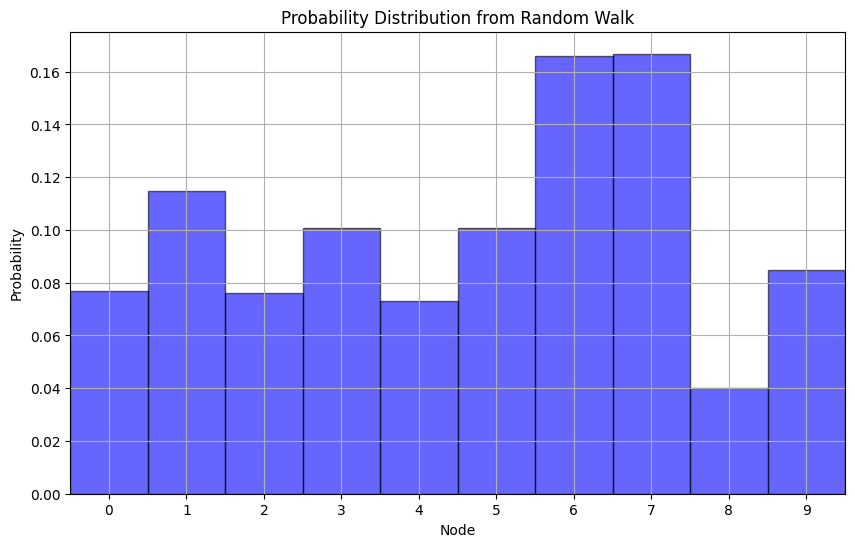

In [13]:
# Simulate a random walk
visited_states = polymer_motion.sample_random_walk(transition_matrix, num_steps)

# Plot the probability distribution of visited states
polymer_motion.plot_probability_distribution(visited_states)

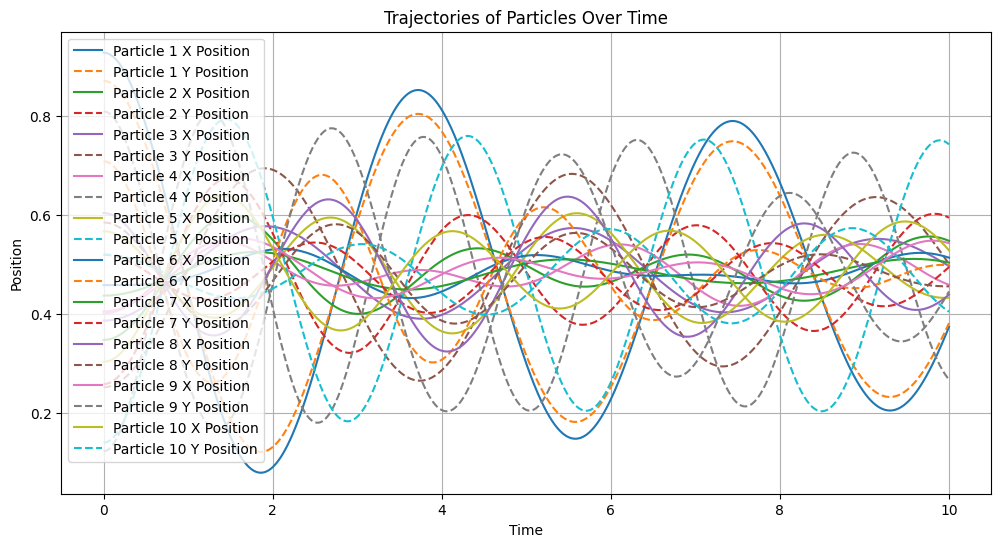

In [14]:
polymer_motion.plot_trajectories()